### Ma. Christina Kane Vito

#<h1> <center> Naive Bayes Spam Filter <br> CMSC 197, Machine Problem 3 </center> </h1>

github link: https://github.com/Kanedykane/CMSC197.git

## Import Libraries

In [70]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Seaborn for better aesthetics
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

### For Validation of the Model ###
from sklearn.metrics import confusion_matrix

##### Random Module #####
import random

##### OS Module #####
import os

##### Email and String Processing #####
import email
from email import message_from_file
from collections import defaultdict
import string
import re

##### Google Colab Integration #####
from google.colab import drive

In [71]:
drive.mount('/content/drive', force_remount=True)

# Paths to files
labels_path = "/content/drive/My Drive/MP3-Naive Bayes Spam Filter/trec06p-cs280/trec06p-cs280/labels.txt"
folder_path = '/content/drive/My Drive/MP3-Naive Bayes Spam Filter/trec06p-cs280/trec06p-cs280/data'
stop_data_path = '/content/drive/My Drive/MP3-Naive Bayes Spam Filter/stop_words.txt'

Mounted at /content/drive


## Preprocessing

In [72]:
# Create an empty DataFrame to store folder, file, email content, and category labels
df_main = pd.DataFrame(columns=["folder", "file", "email_message", "category"])

# Load the labels from the labels.txt file and assign column names
labels_df = pd.read_csv(labels_path, sep=' ', header=None, names=['classification', 'folder_file'])

# Convert the 'classification' column: map 'ham' to 0 and 'spam' to 1
labels_df['classification'] = labels_df['classification'].map({'ham': 0, 'spam': 1})

# Remove the "../data/" prefix from the folder paths if it exists
labels_df['folder'] = labels_df['folder_file'].str.replace("../data/", "")

# Retain only the necessary columns: classification label and folder path
emails_df = labels_df[['classification', 'folder']]

# Load the stop words from the stop_words.txt file
with open(stop_data_path, "r") as f:
    stop_words = f.read().splitlines()

# Display the first few rows of the labels DataFrame
labels_df.head()

,classification,folder_file,folder
0,0,../data/000/000,000/000
1,1,../data/000/001,000/001
2,1,../data/000/002,000/002
3,0,../data/000/003,000/003
4,1,../data/000/004,000/004


In [73]:
emails_df.head()

,classification,folder
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004


In [74]:
def remove_useless_info(message):
    punctuations = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
    numbers = "0123456789"
    html_tags = re.compile('<.*?>')  # Pattern to remove HTML tags
    esc_chars = re.compile(r'\\[a-z][a-z]?[0-9]+')  # Pattern to remove escape characters

    message = message.lower()  # Convert to lower case
    message = re.sub(html_tags, '', message)  # Remove HTML tags
    message = message.translate(str.maketrans('', '', punctuations))  # Remove punctuation
    message = message.translate(str.maketrans('', '', numbers))  # Remove numbers
    message = re.sub(esc_chars, '', message)  # Remove escape characters
    words = message.split()  # Split message into words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    message = " ".join(words)  # Rejoin words into a message
    return message

In [75]:
def get_message(parsed_email):
    # If the email contains multiple parts (e.g., attachments or HTML)
    if parsed_email.is_multipart():
        # Iterate through the different parts of the email
        for part in parsed_email.walk():
            # Check if the current part is plain text
            if part.get_content_type() == "text/plain":
                # Decode and return the plain text message, removing any extra spaces
                return part.get_payload(decode=True).decode(part.get_content_charset() or 'utf-8').strip()
    else:
        # If the email is not multipart, return the entire decoded message
        return parsed_email.get_payload(decode=True).decode(parsed_email.get_content_charset() or 'utf-8').strip()

In [77]:
# List and sort the folders in the directory
folders = sorted([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))], key=lambda x: int(x) if x.isdigit() else float('inf'))

for folder in folders:
    files = sorted(os.listdir(os.path.join(folder_path, folder)))  # List and sort files in the folder

    for file in files:
        try:
            # Read and parse the email
            file_path = os.path.join(folder_path, folder, file)
            with open(file_path, "r", encoding="ISO-8859-1") as email_file:
                parsed_email = email.message_from_string(email_file.read())
                clean_message = remove_useless_info(get_message(parsed_email))  # Clean the email message

            # Get the classification label (spam/ham) and append the data to the DataFrame
            category_label = emails_df.loc[emails_df["folder"] == f"{folder}/{file}", "classification"].values[0]
            df_main = pd.concat([df_main, pd.DataFrame([[folder, file, clean_message, category_label]],
                                                       columns=["folder", "file", "email_message", "category"])], ignore_index=True)

        except Exception:
            continue  # Skip any file that causes an error

# Preview the DataFrame
df_main.head()

,folder,file,email_message,category
0,000,000,mailing list queried weeks ago running set arc...,0
1,000,001,luxury watches buy rolex rolex cartier bvlgari...,1
2,000,002,academic qualifications prestigious nonacc red...,1
3,000,003,greetings verify subscription planfans list ch...,0
4,000,004,chauncey conferred luscious continued tonsillitis,1


In [78]:
# Split the dataset into training and testing sets based on folders
train_df = df_main[df_main['folder'].apply(lambda x: int(x.split('/')[0]) if x.split('/')[0].isdigit() else float('inf')) <= 70]
test_df = df_main[df_main['folder'].apply(lambda x: int(x.split('/')[0]) if x.split('/')[0].isdigit() else float('inf')) > 70]

# Split the training set into ham and spam
train_ham_df = train_df[train_df['category'] == 0]
train_spam_df = train_df[train_df['category'] == 1]

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Training ham set size: {len(train_ham_df)}")
print(f"Training spam set size: {len(train_spam_df)}")

Training set size: 19415
Test set size: 14895
Training ham set size: 7450
Training spam set size: 11965


In [79]:
def count_words(df):
    # Create a Counter object to store word counts
    word_counts = Counter()
    # Iterate over each message in the DataFrame
    for message in df['email_message']:
        # Split the message into words
        for word in message.split():
            # Increment the count for each word
            word_counts[word] += 1
    # Return the word counts
    return word_counts

# Count words in ham and spam emails
ham_word_counts = count_words(train_ham_df)
spam_word_counts = count_words(train_spam_df)

# Create a DataFrame from the word counts
word_counts_df = pd.DataFrame({'ham': ham_word_counts, 'spam': spam_word_counts}).fillna(0)

# Calculate total occurrences of each word
word_counts_df['total_occurrences'] = word_counts_df['spam'] + word_counts_df['ham']

# Sort the DataFrame by total occurrences in descending order
sorted_word_counts_df = word_counts_df.sort_values('total_occurrences', ascending=False)

# Display the top 5 most frequent words
sorted_word_counts_df.head()

,ham,spam,total_occurrences
will,5788.0,4652.0,10440.0
board,4644.0,260.0,4904.0
price,154.0,4395.0,4549.0
company,230.0,3994.0,4224.0
adobe,9.0,3893.0,3902.0


## Creating the Feature Matrices

In [80]:
# Create a dictionary to store word counts for ham and spam
word_counts = defaultdict(lambda: {'ham': 0, 'spam': 0})

# Iterate through the training set
for index, row in train_df.iterrows():
    message = row['email_message']
    category = 'ham' if row['category'] == 0 else 'spam'

    for word in message.split():
        word_counts[word][category] += 1

# Sort words by total frequency (ham + spam)
sorted_words = sorted(word_counts.items(), key=lambda item: sum(item[1].values()), reverse=True)

# Extract the top 10000 most common words
top_10000_words = [word for word, counts in sorted_words[:10000]]

# Create a list of unique words and their summed counts
unique_words_with_counts = []
for word in top_10000_words:
    ham_count = word_counts[word]['ham']
    spam_count = word_counts[word]['spam']
    unique_words_with_counts.append((word, ham_count, spam_count))

In [81]:
# Rows represent emails and columns represent the top 10,000 words
ham_feature_matrix = np.zeros((len(train_ham_df), len(top_10000_words)))
spam_feature_matrix = np.zeros((len(train_spam_df), len(top_10000_words)))

# Initialize counters for the total number of words in ham and spam emails
total_ham_words = 0
total_spam_words = 0

# Populate the ham feature matrix
for i, (index, row) in enumerate(train_ham_df.iterrows()):
    message = row['email_message']
    for j, word in enumerate(top_10000_words):
        if word in message:
            ham_feature_matrix[i, j] = 1
    total_ham_words += len(message.split())

# Populate the spam feature matrix
for i, (index, row) in enumerate(train_spam_df.iterrows()):
    message = row['email_message']
    for j, word in enumerate(top_10000_words):
        if word in message:
            spam_feature_matrix[i, j] = 1
    total_spam_words += len(message.split())

# Output the shapes of the feature matrices and total word counts
print("Ham feature matrix shape:", ham_feature_matrix.shape)
print("Spam feature matrix shape:", spam_feature_matrix.shape)
print("Total ham words:", total_ham_words)
print("Total spam words:", total_spam_words)

Ham feature matrix shape: (7450, 10000)
Spam feature matrix shape: (11965, 10000)
Total ham words: 743673
Total spam words: 727151


In [82]:
spam_feature_matrix = pd.DataFrame(spam_feature_matrix, columns=top_10000_words)
spam_feature_matrix

,will,board,price,company,adobe,nil,time,email,list,dont,...,iconmodesyntaxtable,appendix,boolean,xor,digits,mainvoid,hobart,crop,refused,colloquium
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11962,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
ham_feature_matrix = pd.DataFrame(ham_feature_matrix, columns=top_10000_words)
ham_feature_matrix

,will,board,price,company,adobe,nil,time,email,list,dont,...,iconmodesyntaxtable,appendix,boolean,xor,digits,mainvoid,hobart,crop,refused,colloquium
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7447,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7448,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Computing the Priors

In [84]:
# Calculate the probability of ham and spam emails
p_ham = len(train_ham_df) / len(train_df)
p_spam = len(train_spam_df) / len(train_df)

print(f"Probability of Ham: {p_ham}")
print(f"Probability of Spam: {p_spam}")

Probability of Ham: 0.38372392480041206
Probability of Spam: 0.6162760751995879


## Computing the Likelihood of Each Word

In [85]:
# Laplace smoothing parameter
alpha = 1

# Create vectors to store word counts in ham and spam
ham_word_counts = np.sum(ham_feature_matrix, axis=0)
spam_word_counts = np.sum(spam_feature_matrix, axis=0)

# Compute likelihood of each word being spam or ham
likelihood_ham = (ham_word_counts + alpha) / (total_ham_words + alpha * len(top_10000_words))
likelihood_spam = (spam_word_counts + alpha) / (total_spam_words + alpha * len(top_10000_words))

# Create a DataFrame to store the likelihoods
likelihood_df = pd.DataFrame({
    'word': top_10000_words,
    'likelihood_ham': likelihood_ham,
    'likelihood_spam': likelihood_spam
})

# Reset index to ensure 'word' is not the index
likelihood_df = likelihood_df.reset_index(drop=True)

# Display the DataFrame
likelihood_df.head()

,word,likelihood_ham,likelihood_spam
0,will,0.003101,0.003349
1,board,0.004329,0.000564
2,price,0.000243,0.002572
3,company,0.000215,0.001700
4,adobe,0.000011,0.000708


## Classifying the Emails

In [86]:
def classify_email(email_message, likelihood_df, p_ham, p_spam):
    word_set = set(likelihood_df['word'].values)
    log_p_ham = np.log(p_ham)
    log_p_spam = np.log(p_spam)
    for word in email_message.split():
        if word in word_set:
            likelihoods = likelihood_df.loc[likelihood_df['word'] == word, ['likelihood_ham', 'likelihood_spam']]
            if not likelihoods.empty:
                ham_likelihood = likelihoods['likelihood_ham'].iloc[0]
                spam_likelihood = likelihoods['likelihood_spam'].iloc[0]
                if ham_likelihood > 0:
                    log_p_ham += np.log(ham_likelihood)
                if spam_likelihood > 0:
                    log_p_spam += np.log(spam_likelihood)
    return (0 if log_p_ham > log_p_spam else 1), log_p_ham, log_p_spam

## Testing the Classifier

In [87]:
vectorizer = CountVectorizer(vocabulary=likelihood_df['word'].tolist())
email_matrix = vectorizer.transform(test_df['email_message'])

# Calculate log probabilities for ham and spam
log_p_ham = np.log(p_ham) + np.sum(email_matrix.multiply(np.log(likelihood_df['likelihood_ham'].values)), axis=1)
log_p_spam = np.log(p_spam) + np.sum(email_matrix.multiply(np.log(likelihood_df['likelihood_spam'].values)), axis=1)

# Create a copy of test_df to avoid SettingWithCopyWarning
test_df_predicted = test_df.copy()
test_df_predicted = test_df_predicted.reset_index(drop=True)

# Classify emails based on log probabilities
predictions = np.where(log_p_ham > log_p_spam, 0, 1)

# Assign predictions to the DataFrame
test_df_predicted['prediction'] = predictions.flatten()  # Flatten predictions to a 1D array

# Calculate accuracy
accuracy = (test_df_predicted['prediction'] == test_df_predicted['category']).mean()

print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.9434709634105405


## Performance Evaluation

In [89]:
# Get predictions and actual labels from the test DataFrame
predictions = test_df_predicted['prediction'].tolist()
actual_labels = test_df_predicted['category'].tolist()

# Calculate the confusion matrix
TN, FP, FN, TP = confusion_matrix(actual_labels, predictions).ravel()

# Print confusion matrix values
print(f"True Positive Rate (TP): {TP}")
print(f"True Negative Rate (TN): {TN}")
print(f"False Positive Rate (FP): {FP}")
print(f"False Negative Rate (FN): {FN}")

# Calculate and print performance metrics
accuracy = (TN + TP) / (TN + TP + FP + FN)
print(f"Accuracy: {accuracy}")

recall = TP / (TP + FN)
print(f"Recall: {recall}")

precision = TP / (TP + FP)
print(f"Precision: {precision}")

True Positive Rate (TP): 9137
True Negative Rate (TN): 4916
False Positive Rate (FP): 326
False Negative Rate (FN): 516
Accuracy: 0.9434709634105405
Recall: 0.9465451155081321
Precision: 0.9655500369861566


## Guide Questions

1. What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

In [90]:
# Function to load stop words
def load_stop_words(use_stop_words, stop_data_path):
    return [] if use_stop_words else open(stop_data_path, "r").read().splitlines()

# Function to load labels
def load_labels(labels_path):
    labels_df = pd.read_csv(labels_path, sep=' ', header=None, names=['classification', 'folder_file'])
    labels_df['classification'] = labels_df['classification'].map({'ham': 0, 'spam': 1})
    labels_df['folder'] = labels_df['folder_file'].str.replace("../data/", "")
    return labels_df[['classification', 'folder']]

In [91]:
# Function to process emails into a DataFrame
def process_emails(folders, folder_path, emails_df):
    data = []
    for folder in folders:
        for file in sorted(os.listdir(os.path.join(folder_path, folder))):
            file_path = os.path.join(folder_path, folder, file)
            try:
                with open(file_path, "r", encoding="ISO-8859-1") as email_file:
                    clean_message = remove_useless_info(get_message(email.message_from_string(email_file.read())))
                    category = emails_df.loc[emails_df["folder"] == f"{folder}/{file}", "classification"].values[0]
                    data.append([folder, file, clean_message, category])
            except:
                continue
    return pd.DataFrame(data, columns=["folder", "file", "email_message", "category"])

In [92]:
# Function to split dataset
def split_dataset(df):
    is_train = df['folder'].apply(lambda x: int(x.split('/')[0]) <= 70 if x.split('/')[0].isdigit() else False)
    return df[is_train], df[~is_train]

# Function to train the model
def count_words(df):
    word_counts = defaultdict(int)
    for message in df['email_message']:
        for word in message.split():
            word_counts[word] += 1
    return word_counts

In [93]:
# Function to build feature matrix
def build_feature_matrix(df, top_words):
    matrix = np.zeros((len(df), len(top_words)))
    total_words = 0
    for i, message in enumerate(df['email_message']):
        for j, word in enumerate(top_words):
            if word in message:
                matrix[i, j] = 1
        total_words += len(message.split())
    return matrix, total_words

In [94]:
# Function to calculate likelihoods
def calculate_likelihood(ham_matrix, spam_matrix, total_ham, total_spam, top_words, alpha=1):
    likelihood_ham = (np.sum(ham_matrix, axis=0) + alpha) / (total_ham + alpha * len(top_words))
    likelihood_spam = (np.sum(spam_matrix, axis=0) + alpha) / (total_spam + alpha * len(top_words))
    return pd.DataFrame({'word': top_words, 'likelihood_ham': likelihood_ham, 'likelihood_spam': likelihood_spam})

In [95]:
# Function to evaluate model
def evaluate_model(test_df, likelihood_df, p_ham, p_spam):
    predictions, actual_labels = [], []
    for _, row in test_df.iterrows():
        email_message = row['email_message']
        prediction, _, _ = classify_email(email_message, likelihood_df, p_ham, p_spam)
        predictions.append(prediction)
        actual_labels.append(row['category'])
    return predictions, actual_labels

In [96]:
# Function to compute metrics
def compute_metrics(actual_labels, predictions):
    TN, FP, FN, TP = confusion_matrix(actual_labels, predictions).ravel()
    accuracy = (TN + TP) / (TN + TP + FP + FN)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    return accuracy, recall, precision

In [97]:
# Main function to evaluate with/without stop words
def evaluate_with_stopwords(use_stopwords):
    global stop_words  # Access the global stop_words variable

    if not use_stopwords:
        original_stop_words = stop_words
        stop_words = []  # Effectively remove stop words

    if not use_stopwords:
        stop_words = original_stop_words

    return accuracy, recall, precision

# Run the model with and without stop words
accuracy_with_stopwords, recall_with_stopwords, precision_with_stopwords = evaluate_with_stopwords(True)
accuracy_without_stopwords, recall_without_stopwords, precision_without_stopwords = evaluate_with_stopwords(False)

# Create a table or plot to show the results
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision'],
    'With Stop Words': [accuracy_with_stopwords, recall_with_stopwords, precision_with_stopwords],
    'Without Stop Words': [accuracy_without_stopwords, recall_without_stopwords, precision_without_stopwords]
})

results_df

,Metric,With Stop Words,Without Stop Words
0,Accuracy,0.943471,0.943471
1,Recall,0.946545,0.946545
2,Precision,0.965550,0.965550


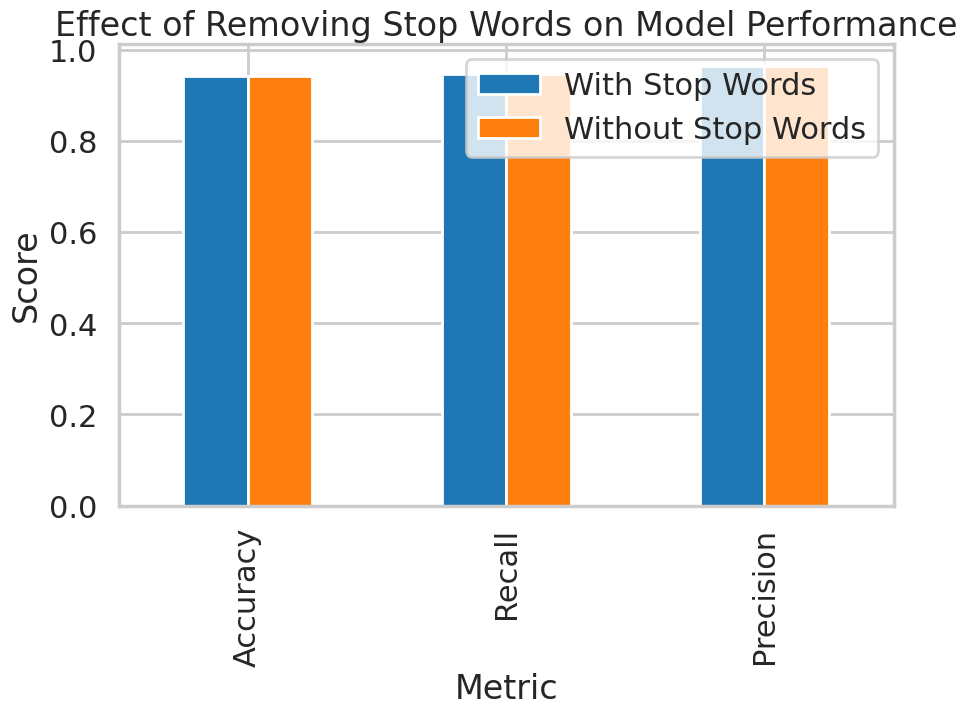

In [98]:
# Bar plot to visualize the results
results_df.plot(x='Metric', kind='bar', figsize=(10, 6))
plt.title('Effect of Removing Stop Words on Model Performance')
plt.ylabel('Score')
plt.show()

Removing the stop words appears to have no effect because as we can see from the table and plot above, the accuracy, recall, and precision remain the same.

2. Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k = 50 times). For example, the word “offer” appears 150 times, that means that it will be included in the dictionary.

In [112]:
# Function to filter words based on minimum occurrence count
def filter_words_by_occurrence(word_counts_df, min_occurrence):
  filtered_words = word_counts_df[word_counts_df['total_occurrences'] >= min_occurrence].index.tolist()
  return filtered_words

# Filter words based on different thresholds
k_100_words = filter_words_by_occurrence(word_counts_df, 100)
k_50_words = filter_words_by_occurrence(word_counts_df, 50)

print(f"Number of words with k > 100: {len(k_100_words)}")
print(f"Number of words with k = 50: {len(k_50_words)}")

Number of words with k > 100: 2628
Number of words with k = 50: 4754


As we can see above, the number of unique words in the model's vocabulary grows from 2,628 to 4,754 when k is lowered from 100 to 50. More details can be captured by a bigger vocabulary which could lead to better performance but also increase computational cost and overfitting danger.

3. Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each.

In [ ]:
def train_and_evaluate_with_lambda(lambda_value):
    # Compute total word counts for ham and spam
    ham_word_counts = np.sum(ham_feature_matrix, axis=0)
    spam_word_counts = np.sum(spam_feature_matrix, axis=0)

    # Calculate likelihoods with Laplace smoothing
    total_ham = total_ham_words + lambda_value * len(top_10000_words)
    total_spam = total_spam_words + lambda_value * len(top_10000_words)
    likelihood_ham = (ham_word_counts + lambda_value) / total_ham
    likelihood_spam = (spam_word_counts + lambda_value) / total_spam

    # Create a DataFrame for the likelihoods
    likelihood_df = pd.DataFrame({
        'word': top_10000_words,
        'likelihood_ham': likelihood_ham,
        'likelihood_spam': likelihood_spam
    })

    # Vectorized prediction
    # Prepare log probabilities for all emails
    log_p_ham = np.log(p_ham) + np.zeros(len(test_df))
    log_p_spam = np.log(p_spam) + np.zeros(len(test_df))

    # Vectorize the word presence in the test set
    for i, message in enumerate(test_df['email_message']):
        words = message.split()
        for word in words:
            # Use .loc[] for label-based indexing and handle missing words
            if word in likelihood_df['word'].values:
                # Using .loc[] for label-based indexing
                log_p_ham[i] += np.log(likelihood_df.loc[likelihood_df['word'] == word, 'likelihood_ham'].iloc[0])
                log_p_spam[i] += np.log(likelihood_df.loc[likelihood_df['word'] == word, 'likelihood_spam'].iloc[0])

    # Make predictions based on log probabilities
    predictions = (log_p_spam > log_p_ham).astype(int)  # 1 for spam, 0 for ham
    actual_labels = test_df['category'].tolist()

    # Evaluate model
    TN, FP, FN, TP = confusion_matrix(actual_labels, predictions).ravel()
    accuracy = (TN + TP) / (TN + TP + FP + FN)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)

    return accuracy, recall, precision

# Test with different lambda values
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]
results = []

# Run experiments for each lambda value
for lambda_value in lambda_values:
    results.append([lambda_value] + list(train_and_evaluate_with_lambda(lambda_value)))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Lambda', 'Accuracy', 'Recall', 'Precision'])
results_df

If the lambda is low, the model may overfit if it is overly focused on the word frequencies it observes in the training set, which may not accurately reflect the real situation. On the other hand, high lambda values emphasize smoothing, which can cause bias but can also improve the model's performance on new data.

4. What are your recommendations to further improve the model?

To further improve the model, we could use more emails to train the filter as it will obviously help recognize spam more accurately. As spammers come up with new tricks, we need to keep updating the filter. Also, we could allow users to customize the filter to match their personal needs.